# Day 6 — Threshold Tuning, ROC & Precision–Recall Curves
### Machine Learning Roadmap — Week 3
### Author — N Manish Kumar
---

Classification models usually predict probabilities, but class labels are
assigned using a fixed threshold, commonly 0.5.

However, different applications require different trade-offs between:
- Precision (avoiding false alarms)
- Recall (detecting all positives)

Therefore, instead of relying on a fixed threshold, we should analyze model
performance across multiple thresholds using:

- ROC Curve (True Positive Rate vs False Positive Rate)
- Precision–Recall Curve (Precision vs Recall)

In this notebook, we will:
- Train a classifier on an imbalanced dataset
- Use predicted probabilities instead of fixed labels
- Plot ROC and Precision–Recall curves
- Understand how threshold affects precision and recall
- Discuss how to choose thresholds based on application goals

---

## 1. Create Imbalanced Dataset and Train/Test Split

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Create imbalanced dataset
X, y = make_classification(
    n_samples=3000,
    n_features=20,
    n_informative=6,
    n_redundant=2,
    weights=[0.9, 0.1],
    random_state=42
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))

Train class distribution: [2153  247]
Test class distribution: [538  62]


---
## 2. Train Classifier and Predict Probabilities

Instead of directly predicting class labels, we now use prediction
probabilities produced by the classifier.

These probabilities allow us to:
- Change classification thresholds
- Plot ROC curves
- Plot Precision–Recall curves

Threshold tuning is only possible when we work with probabilities.


In [4]:
# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicted probabilities for positive class
y_prob = model.predict_proba(X_test)[:, 1]

print("First 10 predicted probabilities:", y_prob[:10])

First 10 predicted probabilities: [9.67508985e-02 6.38015186e-01 2.68319123e-04 7.64740063e-03
 4.88556914e-01 6.04727753e-02 7.90306436e-02 1.44949780e-04
 1.75486268e-01 8.19561674e-01]


---
## 3. Plot ROC Curve and Compute AUC

The ROC curve plots:
- True Positive Rate (Recall)
- vs False Positive Rate

across all possible classification thresholds.

AUC (Area Under Curve) summarizes overall performance:
- AUC = 0.5 → random guessing
- AUC = 1.0 → perfect classifier

ROC curve shows how well the model separates classes independent of threshold.


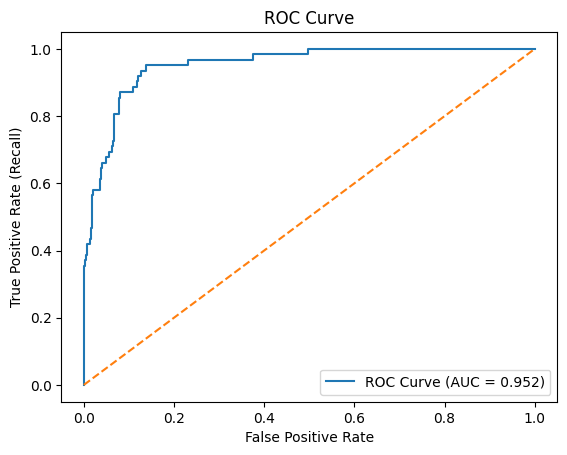

In [5]:
# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Interpretation

The ROC curve shows how recall increases as we allow more false positives.

A curve closer to the top-left corner indicates better class separation.

AUC summarizes this behavior into a single number and is useful for comparing
models, but it does not directly reflect precision on imbalanced datasets.

### Important Point
ROC can look good even when:

Precision is poor

So for imbalanced datasets, we also need Precision–Recall curves.

---
## 4. Plot Precision–Recall Curve

The Precision–Recall (PR) curve shows the trade-off between:
- Precision (how reliable positive predictions are)
- Recall (how many actual positives are detected)

PR curves are more informative than ROC curves when:
- The positive class is rare (imbalanced datasets)

They directly reflect how performance changes when we adjust the threshold.


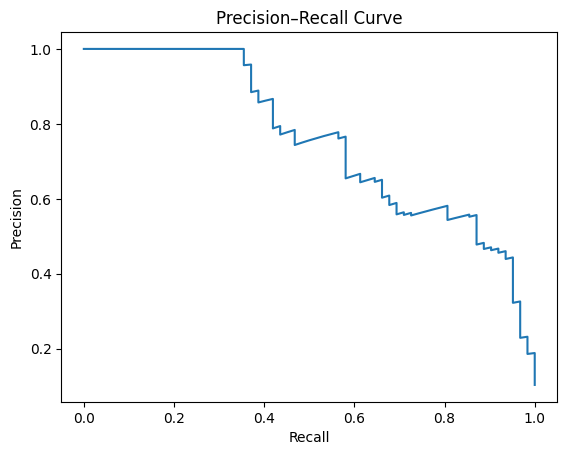

In [6]:
# Compute Precision-Recall curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

### Interpretation

The PR curve shows how precision drops as recall increases.

In many real-world problems, we must decide:
- How much precision we are willing to sacrifice to gain recall
- Or how much recall we are willing to sacrifice to maintain precision

This curve helps choose an operating point based on application needs.

---
## 5. Threshold Tuning and Metric Trade-offs

By default, classifiers use a threshold of 0.5 to convert probabilities
into class labels.

However, changing the threshold allows us to:
- Increase recall by lowering threshold
- Increase precision by raising threshold

We will test different thresholds and observe how precision and recall change.


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds_to_test = [0.2, 0.4, 0.5, 0.7]

results = []

for t in thresholds_to_test:
    y_pred_t = (y_prob >= t).astype(int)
    
    results.append({
        "Threshold": t,
        "Precision": precision_score(y_test, y_pred_t),
        "Recall": recall_score(y_test, y_pred_t),
        "F1": f1_score(y_test, y_pred_t)
    })

pd.DataFrame(results)

,Threshold,Precision,Recall,F1
0,0.2,0.543478,0.806452,0.649351
1,0.4,0.655738,0.645161,0.650407
2,0.5,0.777778,0.564516,0.654206
3,0.7,0.956522,0.354839,0.517647


### Interpretation

Lower thresholds increase recall but reduce precision, meaning more positives
are detected but with more false alarms.

Higher thresholds increase precision but reduce recall, meaning fewer false
positives but more missed positive cases.

Threshold selection must be based on application priorities rather than
default settings.

---
# Notebook Summary — Week 3 Day 6

In this notebook, we studied how classification thresholds affect model
performance and learned to evaluate models using ROC and Precision–Recall curves.

### What was done
- Created an imbalanced classification dataset
- Trained a Logistic Regression classifier
- Generated prediction probabilities instead of fixed labels
- Plotted ROC curve and computed AUC
- Plotted Precision–Recall curve
- Evaluated precision, recall, and F1-score at different thresholds

### Key Learnings
- Default probability threshold (0.5) is not always optimal
- ROC curves evaluate class separation but may be misleading for imbalanced data
- Precision–Recall curves are more informative when positive class is rare
- Lower thresholds increase recall but reduce precision
- Threshold selection must depend on real-world costs of errors

### Final Outcome
The analysis demonstrated how adjusting thresholds allows control over
precision–recall trade-offs, enabling model behavior to be aligned with
application-specific goals.
